In [4]:
!pip install einops pytorch_lightning diffusers==0.12.1 kornia librosa accelerate


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from src import *

mpl.rcParams['figure.figsize'] = (8, 8)

### Creating datasets

torch.Size([1, 256, 256])


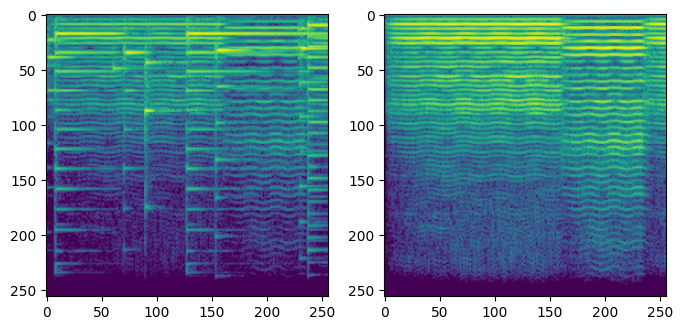

In [6]:
from dataset import SpectrogramDataset

train_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/ins3',
                            condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/mix',
                            return_pair=True,
                            out_channels=1
                     )


valid_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/ins3',
                          condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/mix',
                          return_pair=True,
                          out_channels=1
                     )

test_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/ins3',
                           condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/mix',
                           return_pair=True,
                           out_channels=1
                     )

img1,img2=train_ds[0]
print(img1.shape)

plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(img2.permute(1,2,0))

### Autoencoder Setup

In [7]:
autoencoder = AutoencoderKL(in_channels=1,
                            out_channels=1,
                            down_block_types=("DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D"),
                            up_block_types=("UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D"),
                            block_out_channels=(128,256,512,512),
                            layers_per_block=2,
                            sample_size=256
                            )

pl_ae_model = Autoencoder(autoencoder)


### Autoencoder training

In [9]:
ae_trainer = pl.Trainer(max_steps=2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
train_dl = DataLoader(train_ds, batch_size=5, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=5, shuffle=True)

ae_trainer.fit(pl_ae_model, train_dataloaders=train_dl, val_dataloaders=valid_dl)


  | Name  | Type          | Params
----------------------------------------
0 | model | AutoencoderKL | 83.6 M
----------------------------------------
83.6 M    Trainable params
0         Non-trainable params
83.6 M    Total params
334.597   Total estimated model params size (MB)


Epoch 0:   2%|▏         | 2/100 [03:28<2:49:55, 104.03s/it, v_num=4]       

`Trainer.fit` stopped: `max_steps=2` reached.


Epoch 0:   2%|▏         | 2/100 [03:29<2:51:04, 104.74s/it, v_num=4]


### Testing autoencoder

Text(0.5, 1.0, 'AutoEncoder Reconstruction')

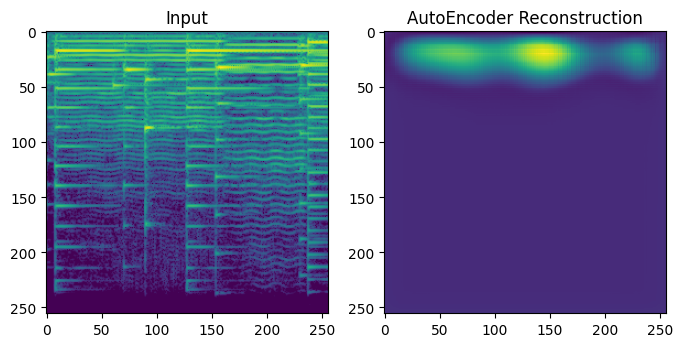

In [11]:
plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.title('Input')
plt.subplot(1,2,2)
plt.imshow(pl_ae_model(img1.unsqueeze(0))[0].detach().cpu().permute(1,2,0))
plt.title('AutoEncoder Reconstruction')

### Model setup

In [13]:
model=LatentDiffusionConditional(train_ds,
                                 autoencoder=pl_ae_model,
                                 valid_dataset=valid_ds,
                                 lr=1e-5,
                                 batch_size=2,
                                 schedule='linear')

Is Time embed used ?  True


### Training

In [14]:
trainer = pl.Trainer(
    max_steps=1,
    callbacks=[EMA(0.9999)],
    accelerator='auto'
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model)


  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | ae    | Autoencoder                          | 83.6 M
1 | model | DenoisingDiffusionConditionalProcess | 56.6 M
---------------------------------------------------------------
140 M     Trainable params
0         Non-trainable params
140 M     Total params
561.087   Total estimated model params size (MB)


Epoch 0:   0%|          | 1/250 [00:09<37:53,  9.13s/it, v_num=5, train_loss=1.020]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0:   0%|          | 1/250 [00:11<47:57, 11.56s/it, v_num=5, train_loss=1.020]


### Load checkpoint

In [ ]:
#model = torch.load('lightning_logs/version_6/checkpoints/epoch=1177-step=37725.ckpt')

### Create sample

In [16]:
input,output=test_ds[0]
batch_input=torch.stack(4*[input],0)

#model.cuda()
out=model(batch_input, verbose=True)

diffusion sampling: 100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]


In [ ]:
plt.subplot(1,2+len(out),1)
plt.imshow(input.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(output.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')

In [ ]:
phase = test_ds.get_phase(0)
print(phase.shape)
print(out[0].shape)
name = test_ds.files[0]
test_ds.save_audio(out[0], phase, name = name)